In [1]:
import xarray as xr
import os
import netCDF4
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import random
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cpu


In [3]:
X=np.load('/work/sds-lab/Shuochen/climsim/val_input.npy')
y=np.load('/work/sds-lab/Shuochen/climsim/val_target.npy')
norm_mean = xr.open_dataset('/work/sds-lab/Shuochen/climsim/normalizations_git/inputs/input_mean.nc')
norm_max = xr.open_dataset('/work/sds-lab/Shuochen/climsim/normalizations_git/inputs/input_max.nc')
norm_min = xr.open_dataset('/work/sds-lab/Shuochen/climsim/normalizations_git/inputs/input_min.nc')
scale = xr.open_dataset('/work/sds-lab/Shuochen/climsim/normalizations_git/outputs/output_scale.nc')

In [4]:
a=torch.tensor([[1,2,3],[4,5,6]])
a.reshape(3,2)

tensor([[1, 2],
        [3, 4],
        [5, 6]])

In [5]:
a.permute(1,0)

tensor([[1, 4],
        [2, 5],
        [3, 6]])

In [9]:
X=np.load('/work/sds-lab/Shuochen/climsim/val_input.npy')
X=torch.Tensor(X)
X_reshape = X.reshape(3755,384,124)
X_final = X_reshape.permute(1,0,2)
X_final.shape

torch.Size([384, 3755, 124])

In [10]:
X_final[10,20,30] * (norm_max - norm_min)['state_t'].isel(lev=30) + norm_mean['state_t'].isel(lev=30)

<xarray.DataArray ()>
array(244.34615074)

In [41]:
X_reshape[20,10,30] * (norm_max - norm_min)['state_t'].isel(lev=30) + norm_mean['state_t'].isel(lev=30)

<xarray.DataArray 'state_t' ()>
array(244.34615074)

In [62]:
mli = xr.open_dataset('/work/sds-lab/Shuochen/climsim/val_mli.nc')
mli['state_t'].isel(lev=30,ncol=10,time=20*7).values

array(244.34615068)

In [63]:
X_reshape_t = X_reshape[:,:,:60] * (norm_max - norm_min)['state_t'].values + norm_mean['state_t'].values
X_reshape_t.shape

(3755, 384, 60)

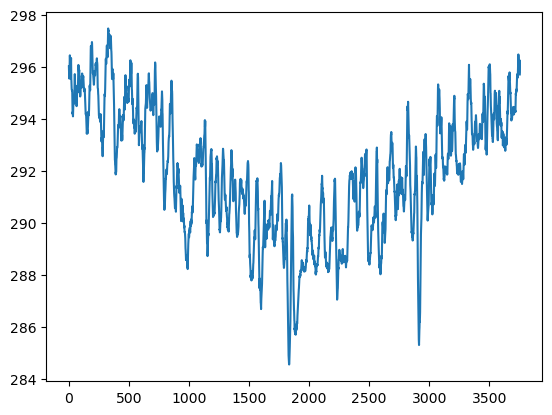

In [77]:
# 59 is the lowest level, data from 0008-02 to 0009-01
plt.plot(X_reshape_t[:,0,59])

# Transformer

In [82]:
test_ts = X_reshape_t[:,0,59]
spots_train = test_ts[:2500]
spots_test = test_ts[2500:]

In [95]:
# Sequence Data Preparation
SEQUENCE_SIZE = 10

def to_sequences(seq_size, obs):
    x = []
    y = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

x_train, y_train = to_sequences(SEQUENCE_SIZE, spots_train)
x_test, y_test = to_sequences(SEQUENCE_SIZE, spots_test)

# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [96]:
x_train[1]

tensor([[295.7914],
        [295.5501],
        [295.5489],
        [295.6279],
        [295.8622],
        [296.1461],
        [296.3852],
        [296.4421],
        [296.3512],
        [296.1318]])

In [85]:
y_train[0]

tensor([296.1318])

In [86]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [89]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

model = TransformerModel().to(device)

In [90]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3, verbose=True)

epochs = 1000
early_stop_count = 0
min_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())

    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 5:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.4f}")

/home/wang.shuoc/.conda/envs/my_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 1/1000, Validation Loss: 79433.5112
Epoch 2/1000, Validation Loss: 73955.7963
Epoch 3/1000, Validation Loss: 66996.6313
Epoch 4/1000, Validation Loss: 59011.5952
Epoch 5/1000, Validation Loss: 50433.4062
Epoch 6/1000, Validation Loss: 41703.7433
Epoch 7/1000, Validation Loss: 33258.9822
Epoch 8/1000, Validation Loss: 25488.8812
Epoch 9/1000, Validation Loss: 18694.8102
Epoch 10/1000, Validation Loss: 13069.2258
Epoch 11/1000, Validation Loss: 8672.2357
Epoch 12/1000, Validation Loss: 5442.8458
Epoch 13/1000, Validation Loss: 3223.0503
Epoch 14/1000, Validation Loss: 1797.8970
Epoch 15/1000, Validation Loss: 946.0142
Epoch 16/1000, Validation Loss: 471.6405
Epoch 17/1000, Validation Loss: 225.0292
Epoch 18/1000, Validation Loss: 104.0731
Epoch 19/1000, Validation Loss: 48.1283
Epoch 20/1000, Validation Loss: 23.3732
Epoch 21/1000, Validation Loss: 12.6894
Epoch 22/1000, Validation Loss: 8.1506
Epoch 23/1000, Validation Loss: 6.1792
Epoch 24/1000, Validation Loss: 5.3218
Epoch 25/1

In [100]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

torch.manual_seed(42)
epochs = 200
train_loss_list = []
test_loss_list = []

for epoch in range(epochs):
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()
        y_pred = model(X.to(device))
        loss = loss_fn(y_pred, y.to(device))
        train_loss += loss # accumulatively add up the loss per epoch 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    train_loss_list.append(train_loss.detach().cpu().numpy())
    
    with torch.inference_mode():
        test_loss = 0
        model.eval()
        for X, y in test_dataloader:
            test_pred = model(X.to(device))
            test_loss += loss_fn(test_pred, y.to(device)) # accumulatively add up the loss per epoch
        
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)
        test_loss_list.append(test_loss.detach().cpu().numpy())
        
    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}")
    

Epoch: 0 | Train loss: 7.13160 | Test loss: 3.80875
Epoch: 50 | Train loss: 7.05098 | Test loss: 3.86311
Epoch: 100 | Train loss: 7.16669 | Test loss: 3.82412
Epoch: 150 | Train loss: 6.97926 | Test loss: 3.87989
